In [1]:
! pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from copy import deepcopy
import utils
import warnings, pylab

warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/content/train_kaggle.csv')
test = pd.read_csv('/content/test_kaggle.csv')
test

,id,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,0,1,1,23.05.2016,1.0,NaN,128.98,119.6
1,1,1,1,24.05.2016,NaN,NaN,128.98,NaN
2,2,1,1,25.05.2016,NaN,NaN,131.70,NaN
3,3,1,1,26.05.2016,NaN,NaN,131.70,NaN
4,4,1,1,27.05.2016,NaN,NaN,131.70,NaN
...,...,...,...,...,...,...,...,...
5965,5965,110,2,15.06.2016,NaN,NaN,133.06,NaN
5966,5966,110,2,16.06.2016,NaN,NaN,133.06,NaN
5967,5967,110,2,17.06.2016,NaN,NaN,133.06,NaN
5968,5968,110,2,18.06.2016,NaN,NaN,133.06,NaN


Заполним пропуски в данных

In [5]:
train['Promo'] = train['Promo'].fillna(0)
train.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
train['Regular_Price'] = train['Regular_Price'].ffill().bfill()
train.reset_index().set_index(['Date'], inplace=True)

test['Promo'] = test['Promo'].fillna(0)
test.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
test['Regular_Price'] = test['Regular_Price'].ffill().bfill()
test.reset_index().set_index(['Date'], inplace=True)

train['Actual_Price'] = train.Promo_Price.combine_first(train.Regular_Price) 
test['Actual_Price'] = test.Promo_Price.combine_first(test.Regular_Price)

Сделаем даты индексами строк

In [6]:
train['Date'] = pd.to_datetime(train['Date'], dayfirst = True)
train.set_index(['Date'], inplace=True)

test['Date'] = pd.to_datetime(test['Date'], dayfirst = True)
test.set_index(['Date'], inplace=True)

Добавим некоторые признаки вручную

In [7]:
train = train.reset_index().copy(deep = True)
train["weekday"] = train.Date.dt.weekday
train["monthday"] = train.Date.dt.day
train['is_weekend'] = train.weekday.isin([5,6])*1

test = test.reset_index().copy(deep = True)
test["weekday"] = test.Date.dt.weekday
test["monthday"] = test.Date.dt.day
test['is_weekend'] = test.weekday.isin([5,6])*1

Инициализируем функции с семинара

In [8]:
from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

# train[['SKU_id', 'Store_id', 'Demand']].groupby(['SKU_id', 'Store_id']).agg({'mean', 'std', percentile(50)})

# добавляем лаги
def lagged_features(df
                    , target_var = 'demand'
                    , org_id_columns = ['product_rk', 'store_location_rk']
                    , all_id_columns =['product_rk', 'store_location_rk', 'period_start_dt']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = None
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_var - column name which is used to calculate lagged features
        org_id_columns - id columns, lagged featires is calculated within each id element independatnly
        all_id_columns - id columns + timestamp column
        lags - 
        windows - list of windows, calculation is performed within time range length of window
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    '''
    out_df = deepcopy(df)

    if filters is None:
      filters = {'':{''}}

    keys, values = zip(*filters.items())
    for bundle in product(*values):
      # print(bundle)
        # define dates for each SKU and Store pairs        
      condition = ' & '.join([keys[i]+ filters[keys[i]][bundle[i]] for i in range(len(keys))])
      name =  '_'.join([bundle[i] for i in range(len(keys))])
      if len(condition) >0:
        _idx = df.eval(condition)
      else:
        _idx = df.index>=0
        
      if len(df[_idx].index)>0:
        for w in windows:
          lf_df = df[_idx].set_index(all_id_columns)[target_var].\
                    groupby(level=org_id_columns).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods))
          for l in lags:
            new_names = {x: "lag{0}_wdw{1}_{2}_{3}".
                          format(l, w, x, name) for x in lf_df.columns }

            out_df = pd.merge(out_df, lf_df.shift(l).reset_index().rename(columns = new_names),
                  how='left', on =all_id_columns )
            

    return out_df

In [9]:
from ipywidgets import IntProgress

from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_
    
# add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col):
    min_date, max_date = x[date_col].min(), x[date_col].max()
    groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
    results = groupby_day.sum(min_count=1)

    idx = pd.period_range(min_date, max_date)
    results = results.reindex(idx, fill_value=np.nan)

    results.index.rename(date_col, inplace=True)

    return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    ## calc preaggregation
    data_preag = data.groupby(group_col).agg(
        preagg_method)[target_cols].reset_index()

    ## fill missing dates
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
        fill_missing_dates, date_col=date_col).drop(group_col[:-1],
                                                    axis=1).reset_index()

    ## return DataFrame with calculated preaggregation and filled missing dates
    return data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):

    ## calc rolling stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
    ## calc ewm stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):

    lf_df = lf_df_filled.groupby(
        level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
    lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

    ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
    return lf_df


def generate_lagged_features(
        data: pd.DataFrame,
        target_cols: list = ['Demand'],
        id_cols: list = ['SKU_id', 'Store_id'],
        date_col: str = 'Date',
        lags: list = [7, 14, 21, 28],
        windows: list = ['7D', '14D', '28D', '56D'],
        preagg_methods: list = ['mean'],
        agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
        dynamic_filters: list = ['weekday', 'Promo'],
        ewm_params: dict = {'weekday': [14, 28], 'Promo': [14, 42]}) -> pd.DataFrame:
    
    ''' 
    data - dataframe with default index
    target_cols - column names for lags calculation
    id_cols - key columns to identify unique values
    date_col - column with datetime format values
    lags - lag values(days)
    windows - windows(days/weeks/months/etc.),
        calculation is performed within time range length of window
    preagg_methods - applied methods before rolling to make
        every value unique for given id_cols
    agg_methods - method of aggregation('mean', 'median', percentile, etc.)
    dynamic_filters - column names to use as filter
    ewm_params - span values(days) for each dynamic_filter
    '''

    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]

    total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)

    for filter_col in dynamic_filters:
        group_col = [filter_col] + id_cols + [date_col]
        for lag in lags:
            for preagg in preagg_methods:
                data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                                    target_cols, preagg)

                ## add ewm features
                for alpha in ewm_params.get(filter_col, []):
                    ewm_filled = calc_ewm(data_preag_filled, group_col,
                                          date_col, alpha)
                    ewm = shift(ewm_filled, group_col, date_col, lag)
                    new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
                        format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}

                    out_df = pd.merge(out_df,
                                      ewm.rename(columns=new_names),
                                      how='left',
                                      on=group_col)
                
                ## add rolling features
                for w in windows:
                    for method in agg_methods:
                        rolling_filled = calc_rolling(data_preag_filled,
                                                      group_col, date_col,
                                                      method, w)

                        ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
                        rolling = shift(rolling_filled, group_col, date_col,
                                        lag)

                        method_name = method.__name__ if type(
                            method) != str else method

                        new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                                     format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

                        out_df = pd.merge(out_df,
                                          rolling.rename(columns=new_names),
                                          how='left',
                                          on=group_col)
                        progress.value += 1

    return out_df

In [10]:
target_cols = ['Demand']
id_cols = ['SKU_id']
date_col = 'Date'
built_in_funcs = [pd.Series.kurtosis, pd.Series.skew]

train['NoFilter'] = 1
train_lagged = generate_lagged_features(train 
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [28, 35, 40]
                    , windows = ['14D', '21D', '28D', '56D']
                    , preagg_methods = ['sum'] # ['mean', 'count']
                    , agg_methods = ['mean' 'count', percentile(25),  percentile(75)]
                    , dynamic_filters = ['Promo', 'NoFilter']
                    , ewm_params={'NoFilter': [14, 28], 'Promo': [14, 28]}
                    )

test['NoFilter'] = 1
test_lagged = generate_lagged_features(test 
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [28, 35, 40]
                    , windows = ['14D', '21D', '28D', '56D']
                    , preagg_methods = ['sum'] # ['mean', 'count']
                    , agg_methods = ['mean', 'min', 'count', percentile(25),  percentile(75)]
                    , dynamic_filters = ['Promo', 'NoFilter']
                    , ewm_params={'NoFilter': [14, 28], 'Promo': [14, 28]}
                    )

IntProgress(value=0, max=120)

IntProgress(value=0, max=120)

In [11]:
train_lagged.set_index('Date', inplace = True)
test_lagged.set_index('Date', inplace = True)

Поделим на временные ряды в зависимости от товара

In [13]:
train11 = train_lagged[train_lagged['SKU_id'] == 1 ]
test11 = test_lagged[test_lagged['SKU_id'] == 1]

train12 = train_lagged[train_lagged['SKU_id'] == 2]
test12 = test_lagged[test_lagged['SKU_id'] == 2 ]

Теперь перейдем к обучению с помощью ML

In [14]:
import lightgbm as lgb
kwargs={'early_stopping_rounds':10,'verbose':2}

def plot_feature_importance(model, X , num = 20): 
  # , fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    # plt.figure(figsize=fig_size)
    # sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

In [15]:
lgbm11 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.05,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')
lgbm11.fit(train11.drop(['SKU_id','Demand'], axis=1), train11.Demand)

lgbm12 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.05,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')
lgbm12.fit(train12.drop(['SKU_id','Demand'], axis=1), train12.Demand)

LGBMRegressor(feature_fraction=0.7, learning_rate=0.05, metric='mae',
              n_estimators=500, num_leaves=40, subsample=0.4)

In [17]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    # size of a fold
    fold_size = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(fold_size))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        train_share = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(fold_size*i)]
        y = y_train[:(fold_size*i)]
        print('Size of train and test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * train_share))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

Разделим обучающую и тестовую выборки на матрицы признаков и вектор таргета.

In [18]:
X_train11 = train11.drop(['SKU_id','Demand'], axis=1)
y_train11 = train11.Demand
X_train12 = train12.drop(['SKU_id', 'Demand'], axis=1)
y_train12 = train12.Demand

X_test11 = test11.drop(['SKU_id','Demand'], axis=1)
y_test11 = test11.Demand
X_test12 = test12.drop(['SKU_id','Demand'], axis=1)
y_test12 = test12.Demand

In [19]:
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

In [20]:
%%time
performTimeSeriesCV(X_train11, y_train11, 8, lgbm11, wape, kwargs)

Size train set: (43733, 141)
Size of each fold: 5466

Splitting the first 2 chunks at 1/2
Size of train and test: (10932, 141)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 311.023
[4]	valid_0's l1: 306.131
[6]	valid_0's l1: 300.578
[8]	valid_0's l1: 294.975
[10]	valid_0's l1: 292.44
[12]	valid_0's l1: 288.455
[14]	valid_0's l1: 286.359
[16]	valid_0's l1: 282.516
[18]	valid_0's l1: 279.624
[20]	valid_0's l1: 277.935
[22]	valid_0's l1: 276.117
[24]	valid_0's l1: 273.272
[26]	valid_0's l1: 271.733
[28]	valid_0's l1: 270.691
[30]	valid_0's l1: 269.547
[32]	valid_0's l1: 267.036
[34]	valid_0's l1: 264.677
[36]	valid_0's l1: 263.541
[38]	valid_0's l1: 262.653
[40]	valid_0's l1: 260.329
[42]	valid_0's l1: 258.478
[44]	valid_0's l1: 256.962
[46]	valid_0's l1: 255.694
[48]	valid_0's l1: 254.43
[50]	valid_0's l1: 254.242
[52]	valid_0's l1: 253.768
[54]	valid_0's l1: 253.033
[56]	valid_0's l1: 252.497
[58]	valid_0's l1: 251.525
[60]	valid_0's l1: 251.258
[62]	va

53.91752878049694

In [21]:
%%time
performTimeSeriesCV(X_train12, y_train12, 8, lgbm12, wape, kwargs)

Size train set: (43183, 141)
Size of each fold: 5397

Splitting the first 2 chunks at 1/2
Size of train and test: (10794, 141)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 2.71645
[4]	valid_0's l1: 2.67628
[6]	valid_0's l1: 2.63493
[8]	valid_0's l1: 2.65054
[10]	valid_0's l1: 2.61566
[12]	valid_0's l1: 2.61403
[14]	valid_0's l1: 2.58068
[16]	valid_0's l1: 2.55578
[18]	valid_0's l1: 2.5613
[20]	valid_0's l1: 2.54298
[22]	valid_0's l1: 2.51908
[24]	valid_0's l1: 2.49632
[26]	valid_0's l1: 2.48967
[28]	valid_0's l1: 2.48089
[30]	valid_0's l1: 2.49625
[32]	valid_0's l1: 2.47376
[34]	valid_0's l1: 2.45404
[36]	valid_0's l1: 2.44518
[38]	valid_0's l1: 2.4407
[40]	valid_0's l1: 2.44115
[42]	valid_0's l1: 2.43338
[44]	valid_0's l1: 2.42975
[46]	valid_0's l1: 2.43039
[48]	valid_0's l1: 2.4316
[50]	valid_0's l1: 2.44103
[52]	valid_0's l1: 2.45437
[54]	valid_0's l1: 2.45136
Early stopping, best iteration is:
[45]	valid_0's l1: 2.42582

Splitting the first 3 chun

85.57179047251101

Построим вектор прогноза 

<AxesSubplot:xlabel='Date'>

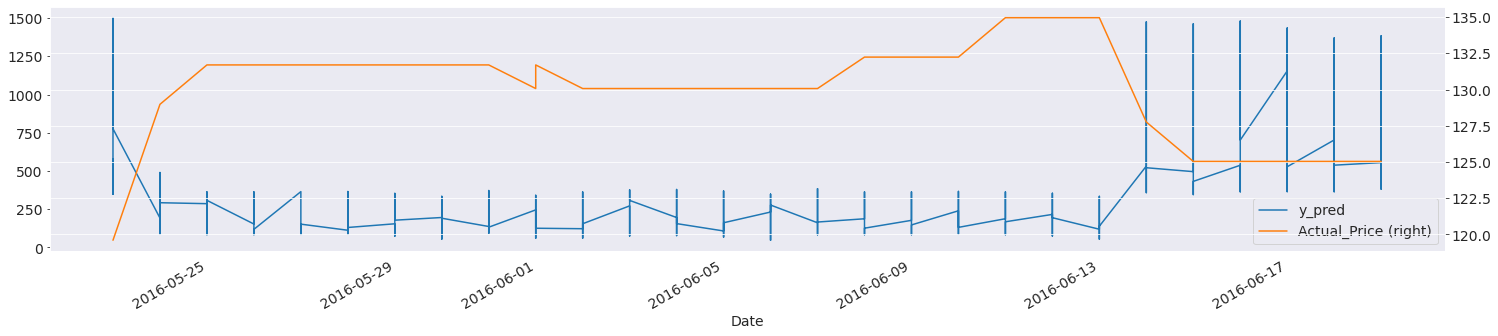

In [22]:
X_test11['y_pred'] = lgbm11.predict(X_test11.drop(columns = ['id']))

<AxesSubplot:xlabel='Date'>

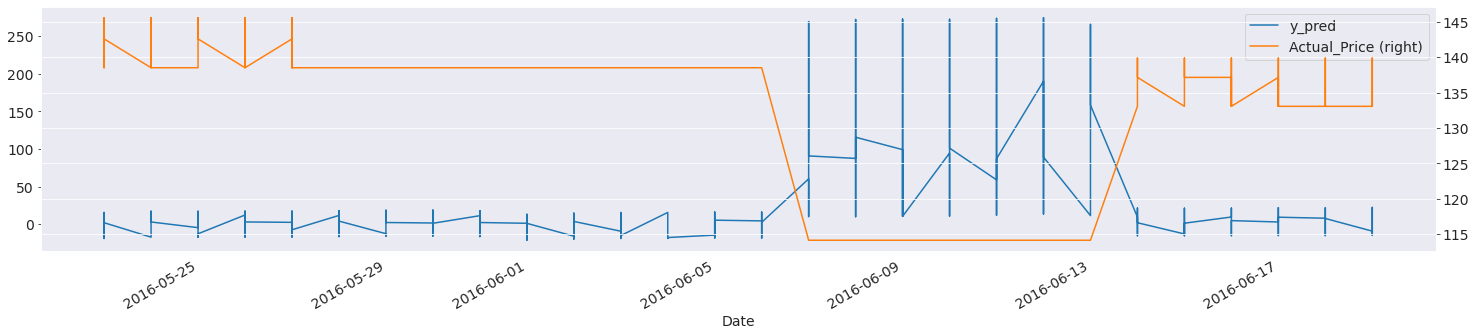

In [23]:
X_test12['y_pred'] = lgbm12.predict(X_test12.drop(columns = ['id']))

Получим ответы для каждой категории товаров

In [24]:
X_pred11 = pd.concat([X_test11['id'], X_test11['y_pred']], axis = 1)
X_pred12 = pd.concat([X_test12['id'], X_test12['y_pred']], axis = 1)

Получим общий вектор ответов

In [25]:
y_pred = pd.concat([X_pred11, X_pred12], axis = 0)
y_pred = y_pred.sort_values(by='id')
y_pred = y_pred.rename(columns = {'y_pred': 'Demand'})

In [26]:
y_pred.reset_index().drop(columns = ['Date', 'id']).to_csv('Attempt_13.csv')